In [1]:
import numpy as np
import os
import pandas as pd
import math

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u

from eventio.simtel.simtelfile import SimTelFile
import matplotlib.pyplot as plt

#%matplotlib
#%matplotlib inline 

Set file to read and folder to save plots

In [2]:
file = '/mnt/yggdrasil_data/prod5/mono-lst-sipm-borofloat-3ns/light_emission/output/ff-1m_r_1nphot_2000000_dist_500_radius_150_event.simtel.gz'

#file = '/home/andrii/work/sem_telarray/test/ff-SST1M.simtel_run_5.gz'

output_dir = '/home/andrii/work/sem_telarray/charge_resolution/'

In [3]:
try:
    os.makedirs(output_dir, exist_ok=True)
    print("Directory ", output_dir, " Created ")
except FileExistsError:
    print("Directory ", output_dir, " already exists")

Directory  /home/andrii/work/sem_telarray/charge_resolution/  Created 


get first 10 events to compare MC input and sim_telarray file

In [4]:
source = EventSource(file, max_events=1, back_seekable=True)
seeker = EventSeeker(source)

TraitError: Path "/mnt/yggdrasil_data/prod5/mono-lst-sipm-borofloat-3ns/light_emission/output/ff-1m_r_1nphot_2000000_dist_500_radius_150_event.simtel.gz" does not exist

In [5]:
for event in source:
    print(event.index)
    camgeom = source.subarray.tel[1].camera.geometry

    fig, (ax0, ax1) = plt.subplots(1, 2)
    disp0 = CameraDisplay(ax=ax0, geometry=camgeom)
    disp1 = CameraDisplay(ax=ax1, geometry=camgeom)

 
    title = "Sum of samples\n in waveforms : event {} ".format(event.index.event_id)
    disp = CameraDisplay(ax=ax0, geometry=camgeom, title=title)
    disp.image = event.r0.tel[1].waveform[0].sum(axis=1)
        
    title = "True Image : event {} ".format(event.index.event_id)
    disp = CameraDisplay(ax=ax1, geometry=camgeom, title=title)
    disp.image = event.simulation.tel[1].true_image

    disp.cmap = plt.cm.viridis
    disp.add_colorbar()
    disp.set_limits_percent(95)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'diplay_r150_pe200_{}.png'.format(event.index.event_id)), dpi=800)
    

{'event_id': 100, 'obs_id': 1}


get all events

In [20]:
source = EventSource(file, max_events=1000, back_seekable=True)
seeker = EventSeeker(source)

create a dictionary of MC p.e. for a given pixel

In [21]:
pe_true_map  = {}

for event in source:
    
    for pixel in range( len(event.r0.tel[1].waveform[0]) ):
        try:
            tmp_pe_list = pe_true_map[pixel]
            tmp_pe_list.append( event.simulation.tel[1].true_image[pixel] )
        except KeyError:
            #LOGGER.debug('Adding new module ID (%s) to the dictionary', module_id)
            tmp_pe_list = [event.simulation.tel[1].true_image[pixel]]
            
        pe_true_map[pixel] = tmp_pe_list
    #for pixel in range(20):

In [22]:
len(pe_true_map[1])

1000

calculate average pe per pixel

In [23]:
pe_true_map_mean = []

for i_pixel in range(len(pe_true_map)):
    pe_true_map_mean.append(np.mean(pe_true_map[i_pixel]))
    
    

In [24]:
x = np.arange(40)

baseline_map  = {}
amplitude_map = {}
waveform_map = {}

baseline = []
amplitude = []

event_int = 0

for event in source:
    
    for pixel in range( len(event.r0.tel[1].waveform[0]) ):
    #for pixel in range(20):
        
        y = event.r0.tel[1].waveform[0][pixel]
        #baseline.append(np.mean(y[:20]))
        #amplitude.append(np.amax(y))
            
        try:
            tmp_baseline_list = baseline_map[pixel]
            tmp_baseline_list.append(np.mean(y[:20]))
        except KeyError:
            #LOGGER.debug('Adding new module ID (%s) to the dictionary', module_id)
            tmp_baseline_list = [np.mean(y[:20])]
        baseline_map[pixel] = tmp_baseline_list
        
        
        try:
            tmp_amplitude_list = amplitude_map[pixel]
            tmp_amplitude_list.append(np.amax(y))
        except KeyError:
            #LOGGER.debug('Adding new module ID (%s) to the dictionary', module_id)
            tmp_amplitude_list = [np.amax(y)]
        amplitude_map[pixel] = tmp_amplitude_list
        
        try:
            tmp_waveform_list = waveform_map[pixel]
            tmp_waveform_list.append(event.r0.tel[1].waveform[0][pixel])
        except KeyError:
            #LOGGER.debug('Adding new module ID (%s) to the dictionary', module_id)
            tmp_waveform_list = [event.r0.tel[1].waveform[0][pixel]]
            
        waveform_map[pixel] = tmp_waveform_list       

            
        #plt.plot(x, y)
        
    event_int = event_int + 1
        
#plt.grid(True)
#plt.show()

/home/andrii/anaconda3/envs/cta/lib/python3.7/site-packages/ctapipe/io/simteleventsource.py:347: UserWarning: Backseeking to start of file.
  warnings.warn("Backseeking to start of file.")


In [25]:
baseline_list = []
baseline_mean = []
amplitude_list = []
amplitude_corrected = []
amplitude_corrected_mean = []
waveform_list = []
std_list = []
charge_resolution = []

p_xt = 0.08

print(event_int)

for pixel in range( len(baseline_map) ):
    baseline_list.append(baseline_map[pixel][:])
    
    baseline_mean.append(np.mean(baseline_list[pixel]))
    
    amplitude_list.append(amplitude_map[pixel][:])
    
    amplitude_corrected.append(amplitude_list[pixel] - baseline_mean[pixel])
    amplitude_corrected_mean.append( np.mean(amplitude_corrected[pixel]) )
    
    waveform_list.append(waveform_map[pixel][:])
    std_list.append(0.)
    
    for event_id in range(len(baseline_map[pixel])):
        std_list[pixel] = std_list[pixel] + ( (amplitude_corrected[pixel][event_id] -  amplitude_corrected_mean[pixel]) )**2
    
    std_list[pixel] = std_list[pixel]/( len(baseline_map[pixel]) - 1)
    std_list[pixel] = math.sqrt(std_list[pixel])
    
    charge_resolution.append(std_list[pixel]/amplitude_corrected_mean[pixel])
    
std_list[0]
print(std_list[0]/amplitude_corrected_mean[0])
print(charge_resolution[0])

1000
0.5367246611459324
0.5367246611459324


In [26]:
charge_resolution_poisson = []
pe_poisson = np.arange(1, 140, 1)

for i in range(len(pe_poisson)):
    charge_resolution_poisson.append(1./math.sqrt(pe_poisson[i]))

charge_resolution_poisson

[1.0,
 0.7071067811865475,
 0.5773502691896258,
 0.5,
 0.4472135954999579,
 0.4082482904638631,
 0.3779644730092272,
 0.35355339059327373,
 0.3333333333333333,
 0.31622776601683794,
 0.30151134457776363,
 0.2886751345948129,
 0.2773500981126146,
 0.2672612419124244,
 0.2581988897471611,
 0.25,
 0.24253562503633297,
 0.23570226039551587,
 0.22941573387056174,
 0.22360679774997896,
 0.2182178902359924,
 0.21320071635561041,
 0.20851441405707477,
 0.20412414523193154,
 0.2,
 0.19611613513818404,
 0.19245008972987526,
 0.1889822365046136,
 0.18569533817705186,
 0.18257418583505536,
 0.1796053020267749,
 0.17677669529663687,
 0.17407765595569785,
 0.17149858514250882,
 0.1690308509457033,
 0.16666666666666666,
 0.1643989873053573,
 0.16222142113076254,
 0.16012815380508713,
 0.15811388300841897,
 0.15617376188860607,
 0.1543033499620919,
 0.15249857033260467,
 0.15075567228888181,
 0.14907119849998599,
 0.14744195615489714,
 0.14586499149789456,
 0.14433756729740646,
 0.14285714285714285,
 

In [27]:
plt.plot(pe_true_map_mean, charge_resolution, ".")
plt.plot(pe_poisson, charge_resolution_poisson, "--")
plt.grid(True)
plt.xlabel('N p.e. detected')
plt.ylabel('Charge resolution')
plt.show()

#print(len(pe_true_map_mean))
#print(len(charge_resolution))

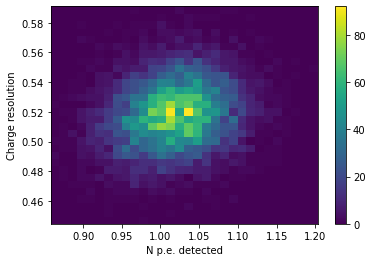

In [28]:
plt.hist2d(pe_true_map_mean, charge_resolution, bins=30)
plt.xlabel('N p.e. detected')
plt.ylabel('Charge resolution')
plt.plot(pe_poisson, charge_resolution_poisson, "r--")
plt.colorbar()
plt.savefig('charge_resolution.png', dpi=800)
plt.show()

In [16]:
plt.plot(x, waveform_list[7000][1])
plt.grid(True)
plt.show()

print(len(baseline_map[0]))

100


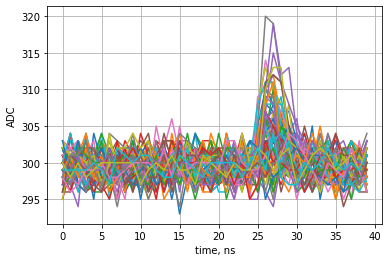

In [17]:
for event_id in range( len(baseline_map[0]) ):
    plt.plot(x, waveform_list[0][event_id])
    
plt.grid(True)
plt.xlabel('time, ns')
plt.ylabel('ADC')
plt.show()

/home/andrii/anaconda3/envs/cta/lib/python3.7/site-packages/ctapipe/io/simteleventsource.py:347: UserWarning: Backseeking to start of file.
  warnings.warn("Backseeking to start of file.")


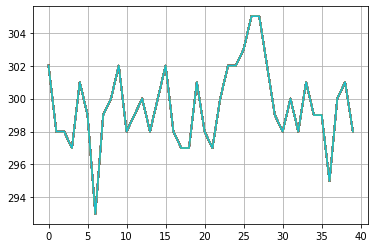

In [18]:
event_int = 0
pixel_to_show = 10

for event in source:
    
    plt.plot(x, waveform_list[pixel_to_show][0])
    event_int = event_int + 1
    
plt.grid(True)
plt.show()
    

mean baseline :  299.1279


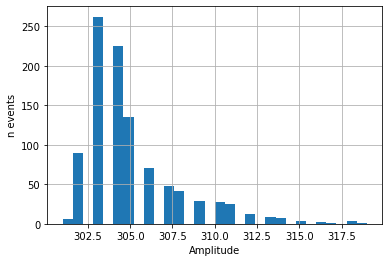

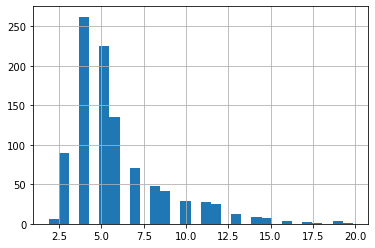

mean amplitude :  5.886099999999989


In [29]:
pixel_to_show = 10

plt.hist(baseline_map[pixel_to_show], bins='auto')
plt.xlabel('Baseline')
plt.ylabel('n events')
plt.grid(True)
plt.show()

print('mean baseline : ', baseline_mean[pixel_to_show])

plt.hist(amplitude_map[pixel_to_show], bins='auto')
plt.grid(True)
plt.xlabel('Amplitude')
plt.ylabel('n events')
plt.show()

plt.hist(amplitude_corrected[pixel_to_show], bins='auto')
plt.grid(True)
plt.show()

print('mean amplitude : ', amplitude_corrected_mean[pixel_to_show])


plt.hist(pe_true_map[pixel_to_show], bins='auto')
plt.grid(True)
plt.xlabel('N p.e. detected')
plt.ylabel('n events')
plt.show()

plt.hist(std_list, bins='auto')
plt.grid(True)
plt.xlabel('STD, ADC')
plt.ylabel('n events')
plt.show()
